# Diabetes detection
In this notebook we will explore how to detect diabetes from some indicators.

# Libraries

In [2]:
# basic
import os
import sys
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data processing
from sklearn.model_selection import train_test_split

# RandomForest
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, auc, classification_report
# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from tensorflow.keras.metrics import Recall
from keras_tuner import RandomSearch
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
# random seed
random_seed=14
# show versions installed
print(f'Python version {sys.version}')
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version {np.__version__}')
print(f'Tensorflow version {tf.__version__}')

Python version 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.3.2
Numpy version 1.26.4
Tensorflow version 2.10.0


# Data
Import and process data

In [3]:
# import data
df=pd.read_csv(r'data/diabetes_dataset.csv')
# general infomration from dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 100000 non-null  int64  
 1   gender                              100000 non-null  object 
 2   ethnicity                           100000 non-null  object 
 3   education_level                     100000 non-null  object 
 4   income_level                        100000 non-null  object 
 5   employment_status                   100000 non-null  object 
 6   smoking_status                      100000 non-null  object 
 7   alcohol_consumption_per_week        100000 non-null  int64  
 8   physical_activity_minutes_per_week  100000 non-null  int64  
 9   diet_score                          100000 non-null  float64
 10  sleep_hours_per_day                 100000 non-null  float64
 11  screen_time_hours_per_day  

In [4]:
df.head(5)

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


In [5]:
# checking null or NA values
null_values=df.isnull().sum()
if null_values.sum()==0:
    print('There are NO null values!')
else:
    print('There are null values!')

na_values=df.isna().sum()
if na_values.sum()==0:
    print('There are NO na values!')
else:
    print('There are NA values')

There are NO null values!
There are NO na values!


We can carry out various studies using one of following predictors:
- **Binary classification** using `diagnosed_diabetes` (yes/no)
- **Multiclass classification** using `diabetes_stage`
- **Regression** using:
    - `glucose_fasting`
    - `hba1c`
    - `diabetes_risk_score`

Therefore, we will separate these targets form the dataset.

In [6]:
# separating predictors and targets
X=df.drop(columns=['diagnosed_diabetes', 'diabetes_stage', 'glucose_fasting','hba1c', 'diabetes_risk_score'])

# targets

# binary classification
y_bin=df['diagnosed_diabetes']
# multiclass classification
y_multi=df['diabetes_stage']
# regresion
y_reg=df['diabetes_risk_score']

In addition, these are categorical predictors
- `gender`
- `ethnicity`
- `education_level`
- `income_level`
- `employment_status`
- `smoking_status`
- `family_history_daibetes`
- `hypertension_history`
- `cardiovascular_history`

In [7]:
categoric_columns=[
    'gender',
    'ethnicity',
    'education_level',
    'income_level',
    'employment_status',
    'smoking_status',
    'family_history_diabetes',
    'hypertension_history',
    'cardiovascular_history'
]
# numerical predictors
X_num=X.drop(columns=categoric_columns)
# categorical predictors
X_cat=X[categoric_columns]

print(f'Numeric predictors shape: {X_num.shape}')
print(f'Categoric predictors shape {X_cat.shape}')

Numeric predictors shape: (100000, 17)
Categoric predictors shape (100000, 9)


# EDA

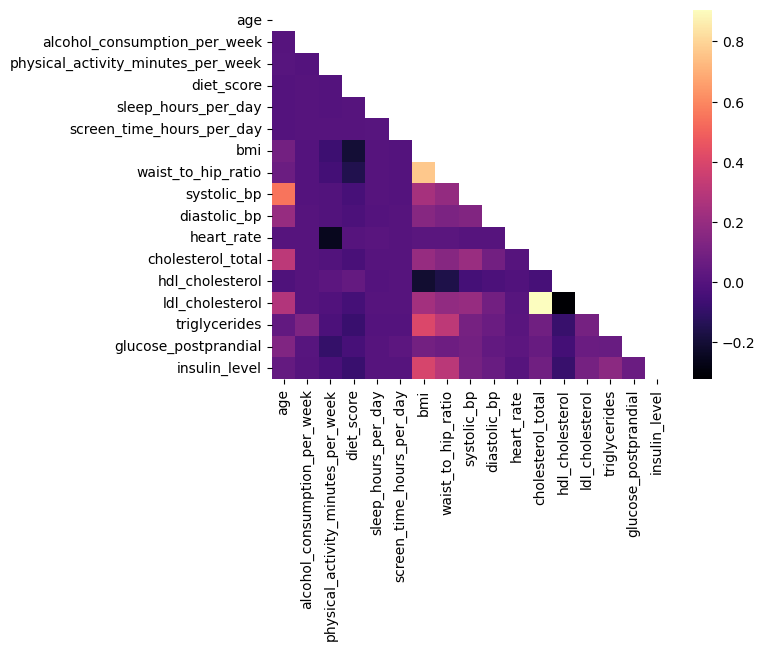

In [8]:
# correlation map
cor=X_num.corr()
# mask to show jsut the upper triangle
mask=np.triu(cor)
sns.heatmap(cor, cmap='magma', mask=mask)
plt.show()

In [9]:
corr_pairs = cor.unstack()

corr_pairs = corr_pairs.drop_duplicates().sort_values(ascending=False)

top5 = corr_pairs.abs().sort_values(ascending=False).head(5)

print('Principal correlations\n__________')
print(top5)

Principal correlations
__________
age                age                   1.000000
cholesterol_total  ldl_cholesterol       0.906132
bmi                waist_to_hip_ratio    0.765744
age                systolic_bp           0.547696
bmi                triglycerides         0.405668
dtype: float64


## Binary analysis

In [10]:
df_bin_num=pd.concat([X_cat, y_bin], axis=1)

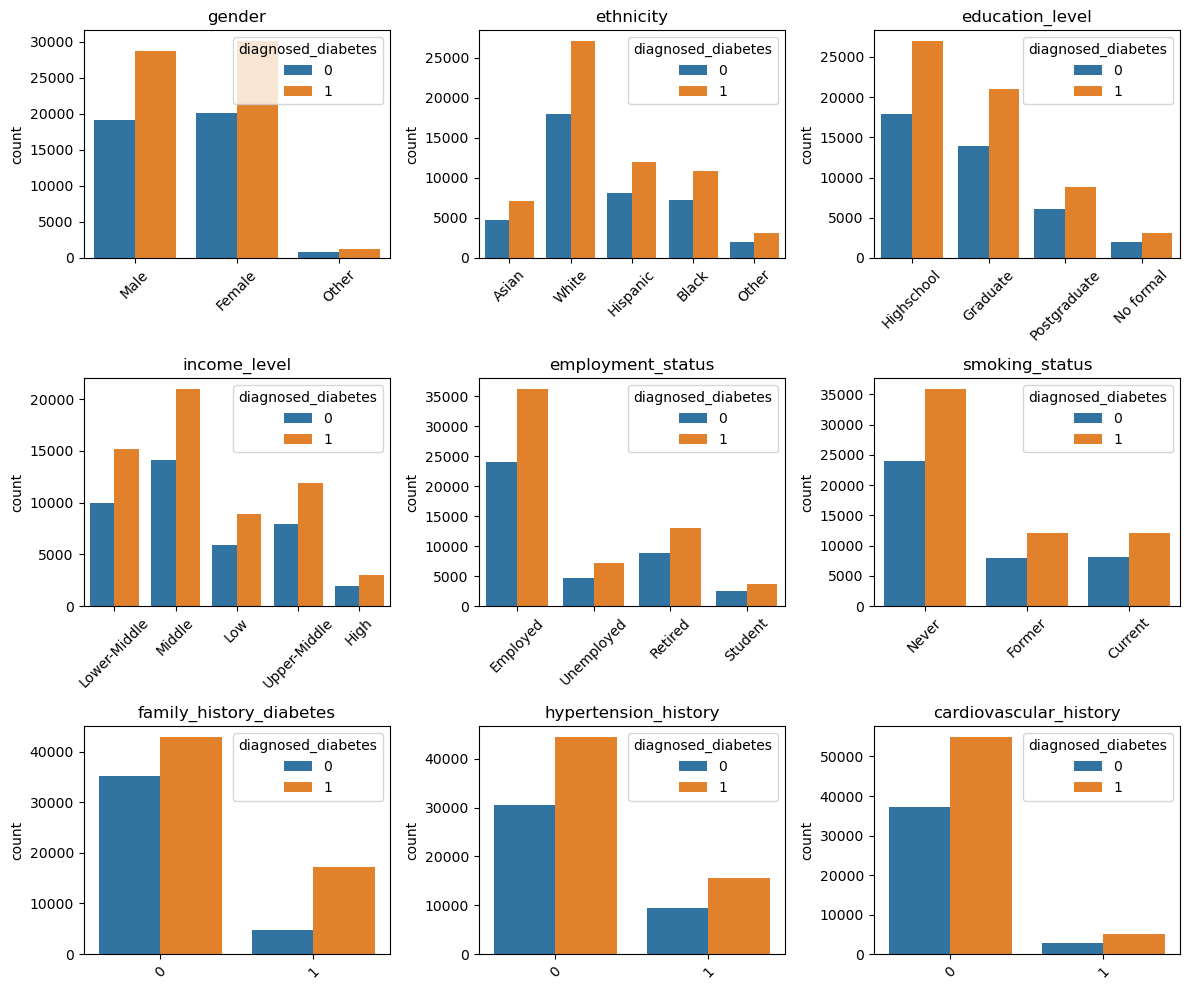

In [11]:
# combine categorical values and binary target
df_cat_bin=pd.concat([X_cat, y_bin], axis=1)

fig, axes=plt.subplots(3, 3, figsize=(12,10))
axes=axes.flatten()

for i, column in enumerate(X_cat.columns):
    sns.countplot(data=df_cat_bin, x=column, hue='diagnosed_diabetes', ax=axes[i])
    axes[i].set_title(column)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('')

for j in range(len(X_cat.columns), len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

## Multiclass analysis

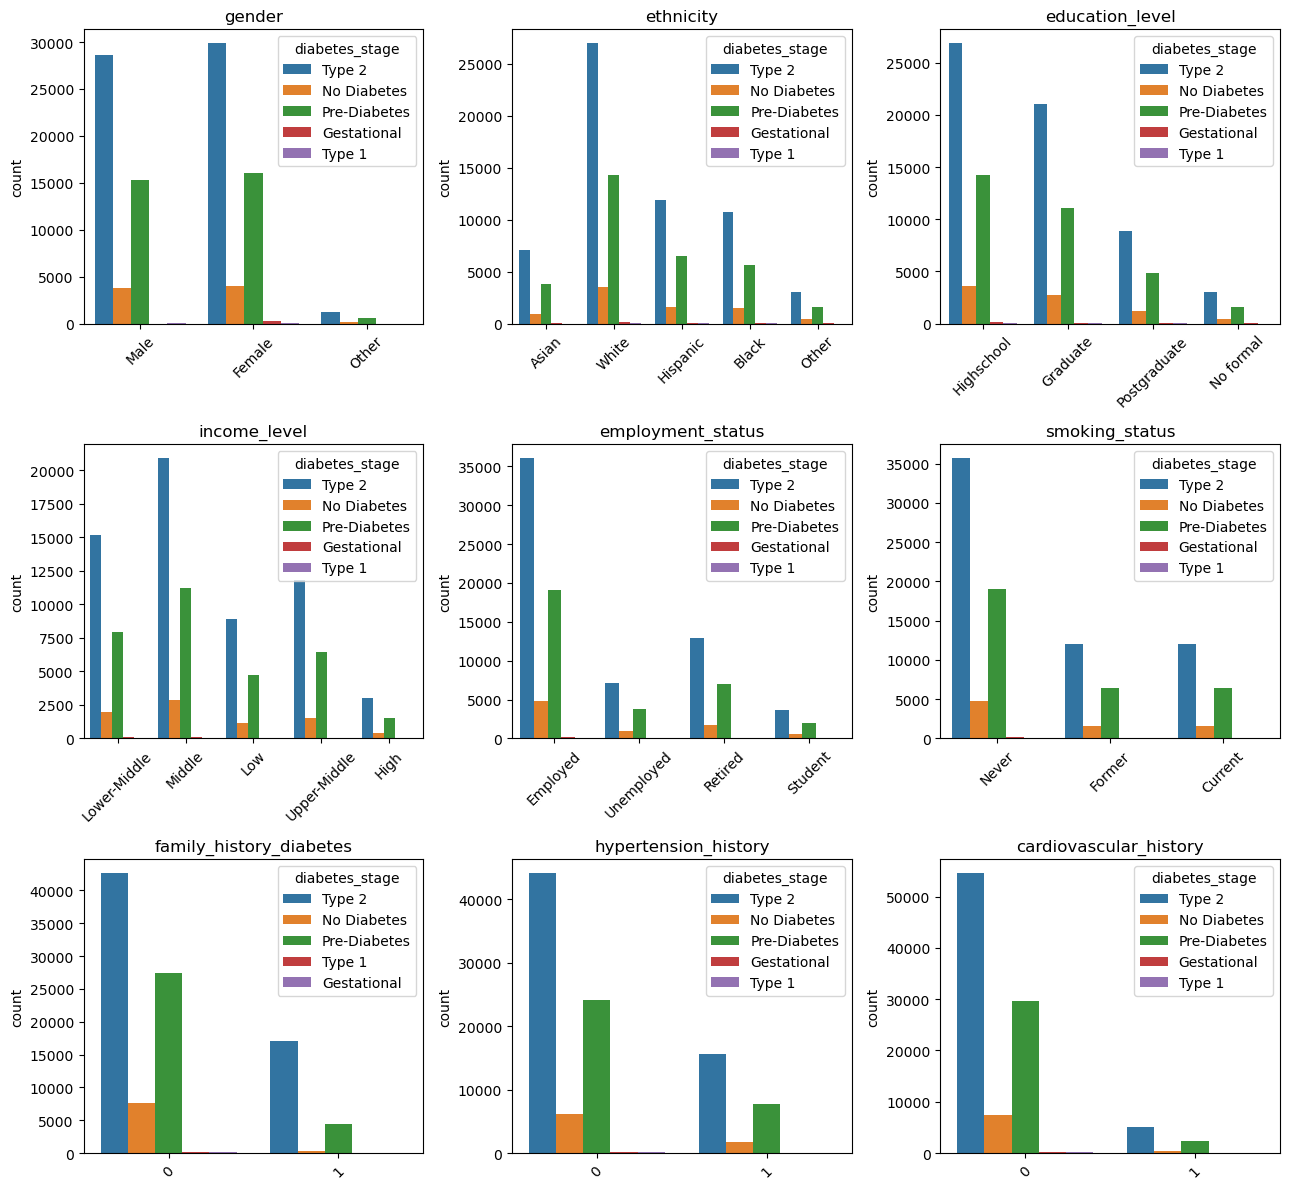

In [12]:
# put together numeric and multiclass target in a single dataframe
df_num_multi=pd.concat([X_cat, y_multi], axis=1)

fig, axes=plt.subplots(3,3, figsize=(13,12))
axes=axes.flatten()

for i, column in enumerate(X_cat.columns):
    sns.countplot(data=df_num_multi, x=column, ax=axes[i], hue='diabetes_stage')
    axes[i].set_title(column)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('')

for j in range(len(X_cat.columns), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

# Data preprocessing 

In [13]:
y_bin.head(2)

0    1
1    0
Name: diagnosed_diabetes, dtype: int64

In [14]:
y_multi.head(2)

0         Type 2
1    No Diabetes
Name: diabetes_stage, dtype: object

In [15]:
# encoding categoric data
X_cat_encoded=pd.get_dummies(X_cat, dtype=int)
print(f'Categorical predictors has been encoded, now we have {len(X_cat_encoded.columns)} columns!')

# encoding target data
y_multi_encoded=pd.get_dummies(y_multi, dtype=int)

Categorical predictors has been encoded, now we have 27 columns!


In [42]:
# concat data
X_data=pd.concat([X_num, X_cat_encoded], axis=1)

# split predictors

X_train, X_test=train_test_split(X_data, test_size=0.3, random_state=random_seed)

# split target
y_bin_train, y_bin_test=train_test_split(y_bin, test_size=0.3, random_state=random_seed)
y_multi_train, y_multi_test=train_test_split(y_multi_encoded, test_size=0.3, random_state=random_seed, stratify=y_multi_encoded)
y_reg_train, y_reg_test=train_test_split(y_reg, test_size=0.3, random_state=random_seed)


# Binary analysis 
## Random forest classifier

In [17]:
# first estimation of random forest
rf=RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1,
    criterion='gini'
)
rf.fit(X_train, y_bin_train)
y_rf_pred=rf.predict(X_test)

# model evaluation
print(f'Random forest classifier perfomance\n {rf}\n_________________')
print('Accuracy', accuracy_score(y_bin_test, y_rf_pred))
print('Presicion', precision_score(y_bin_test, y_rf_pred))
print('Recall', recall_score(y_bin_test, y_rf_pred))
print('F1 score', f1_score(y_bin_test, y_rf_pred))

Random forest classifier perfomance
 RandomForestClassifier(n_jobs=-1)
_________________
Accuracy 0.8243333333333334
Presicion 0.8781577693040992
Recall 0.8204742818971276
F1 score 0.8483365949119374


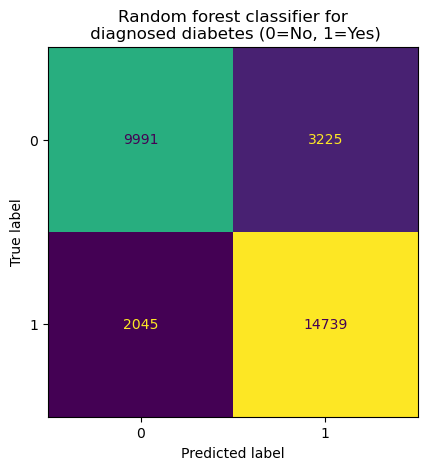

In [18]:
cf=confusion_matrix(y_rf_pred, y_bin_test)
cf_display=ConfusionMatrixDisplay(cf)
cf_display.plot(colorbar=False)
plt.title(f'Random forest classifier for\n diagnosed diabetes (0=No, 1=Yes)')
plt.show()

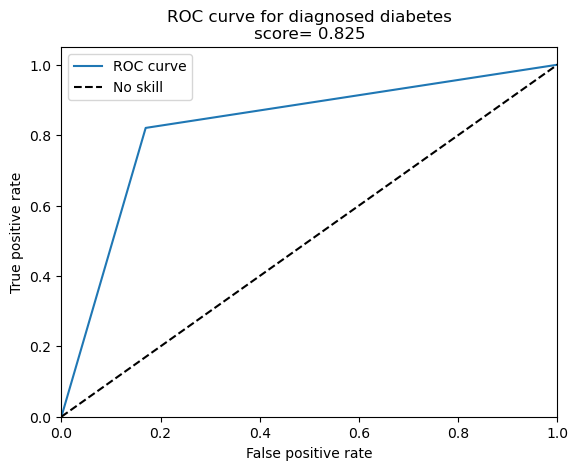

In [19]:
# ROC curve
fpr, tpr, thresholds= roc_curve(y_bin_test, y_rf_pred)
# roc score
roc_score=roc_auc_score(y_bin_test, y_rf_pred)
sns.lineplot(x=fpr, y=tpr, label='ROC curve')
sns.lineplot(x=[0,1],y=[0,1], linestyle='--', color='black', label='No skill')
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve for diagnosed diabetes\nscore= {roc_score:.3}')
plt.show()

## Neural network

In [20]:
tf.random.set_seed(42)

model = keras.Sequential([
    Dense(50, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(40, activation='relu'),
    Dropout(0.2),
    Dense(30, activation='relu'),
    Dense(1, activation='sigmoid')
], name="Binary_Classifier_Model")

model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model.fit(
    X_train, y_bin_train,
    epochs=200,
    batch_size=100,
    validation_split=0.3,
    callbacks=[callback],
    verbose=0
)

Model: "Binary_Classifier_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                2250      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                2040      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                1230      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 5,551
Trainable params: 5,551

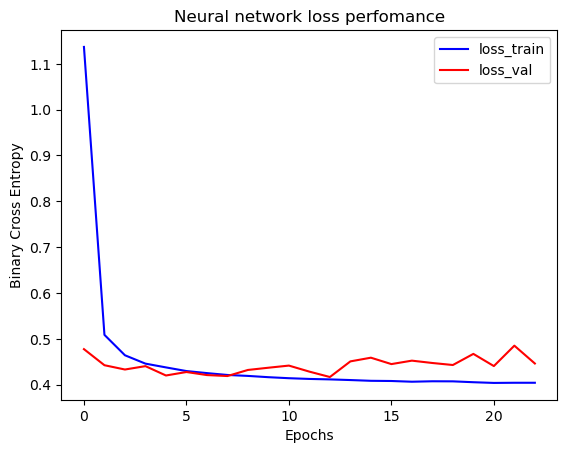

In [21]:
# Gráfica la función de pérdida
plt.figure()
plt.plot(history.history["loss"], "blue", label="loss_train")
plt.plot(history.history["val_loss"], "red", label="loss_val")
plt.title("Neural network loss perfomance")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy")
plt.legend()
plt.show()

In [22]:
# predictions
y_pred_prob=model.predict(X_test)

# convert to binary values
y_nn_pred=(y_pred_prob>0.5).astype(int)

# classification report
print(classification_report(y_bin_test, y_nn_pred))


938/938 [==============================] - 4s 4ms/step
              precision    recall  f1-score   support

           0       0.73      0.83      0.78     12036
           1       0.88      0.79      0.83     17964

    accuracy                           0.81     30000
   macro avg       0.80      0.81      0.80     30000
weighted avg       0.82      0.81      0.81     30000



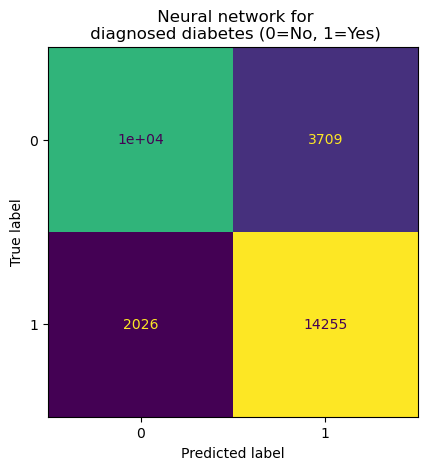

In [23]:
cf=confusion_matrix(y_nn_pred, y_bin_test)
cf_display=ConfusionMatrixDisplay(cf)
cf_display.plot(colorbar=False)
plt.title(f' Neural network for\n diagnosed diabetes (0=No, 1=Yes)')
plt.show()

### Looking for best params

In [24]:
X_train.shape

(70000, 44)

In [25]:
# using keras tuner
def build_model(hp):
    # input shape
    inputs=keras.Input(shape=(44, ))
    x=inputs

    # iterable options
    choice_layers=hp.Int('num_layers', min_value=1, max_value=5)
    choice_units=hp.Int('num_units', min_value=20, max_value= 100, step=10)
    choice_activation=hp.Choice('activation', values=['relu', 'tanh'])
    choice_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    # hidden layers
    for i in range(choice_layers):
        x=keras.layers.Dense(
            units=choice_units,
            activation=choice_activation,
            kernel_initializer='he_normal'
        )(x)
        # dropout per layer
        if hp.Boolean(f'use_dropout{i}'):
            x=keras.layers.Dropout(rate=hp.Float(f'Dropout_rate {i}', min_value=0.1, max_value=0.5, step=0.1))(x)
    # output layer
    outputs=keras.layers.Dense(1, activation='sigmoid')(x)
    model=keras.Model(inputs=inputs, outputs=outputs) 
    
    # optimizer
    optimizer=keras.optimizers.Adam(learning_rate=choice_learning_rate)

    # compilation
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[Recall()]
    )
    return model


In [26]:
# creating callbacks

# listo of callbacks
callbacks=[]

# early stopping if the model does not imporve
callbacks.append(
    EarlyStopping(
        monitor='val_recall',
        patience= 5, # epochs
        restore_best_weights=True
    )
)

# save the best model
os.makedirs('checkpoints', exist_ok=True)

callbacks.append(
    ModelCheckpoint(
        filepath='checkpoints/best_model.keras',
        monitor='val_recall',
        save_best_only=True
    )
)

# logs for tensorboard
callbacks.append(
    TensorBoard(
        log_dir='logs'
    )
)

In [27]:
tuner = RandomSearch(
    build_model,
    objective=keras_tuner.Objective('val_recall', direction='max'),
    max_trials=20,
    executions_per_trial=1,
    directory="tuning_mlp",
    project_name="diabetes_binary_classification"
)

tuner.search(
    X_train, y_bin_train,
    validation_data=(X_test, y_bin_test),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

Trial 20 Complete [00h 04m 20s]
val_recall: 0.8699621558189392

Best val_recall So Far: 1.0
Total elapsed time: 01h 27m 14s
{'num_layers': 3, 'num_units': 50, 'activation': 'relu', 'learning_rate': 0.0003003965636506952, 'use_dropout0': True, 'use_dropout1': True, 'use_dropout2': True, 'use_dropout3': False, 'use_dropout4': True, 'Dropout_rate 0': 0.4, 'Dropout_rate 1': 0.2, 'Dropout_rate 2': 0.5, 'Dropout_rate 3': 0.2, 'Dropout_rate 4': 0.5}


In [28]:
# loading best model
best_model=load_model(r'checkpoints/best_model.keras')

# doing predictions
y_pred=best_model.predict(X_test)

938/938 [==============================] - 6s 6ms/step


In [29]:
y_pred

array([[0.4988179 ],
       [0.9358713 ],
       [0.9498743 ],
       ...,
       [0.21913028],
       [0.9991473 ],
       [0.7229141 ]], dtype=float32)

In [30]:
# covert into binary
y_pred_bin=(y_pred>0.5).astype(int)
# making classification report
print(classification_report(y_bin_test, y_pred_bin))

              precision    recall  f1-score   support

           0       0.72      0.81      0.76     12036
           1       0.86      0.79      0.82     17964

    accuracy                           0.80     30000
   macro avg       0.79      0.80      0.79     30000
weighted avg       0.80      0.80      0.80     30000



# Multiclass analysis
In this section we will explore the same dataset changing the target to multiclass labels that include diabetes types.

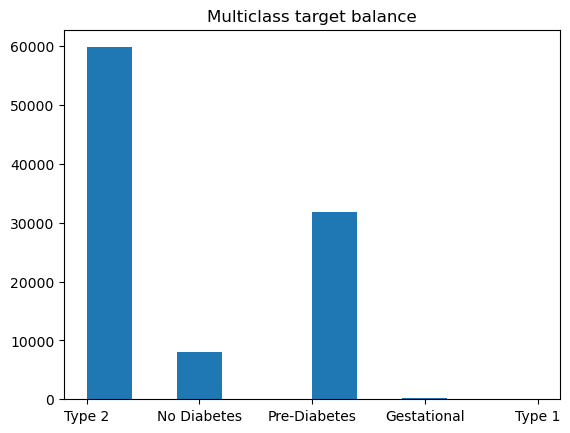

In [52]:
plt.hist(y_multi)
plt.title('Multiclass target balance')
plt.show()

## Random forest

In [35]:
y_multi_encoded.head()

,Gestational,No Diabetes,Pre-Diabetes,Type 1,Type 2
0,0,0,0,0,1
1,0,1,0,0,0
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [37]:
len(y_multi_encoded.columns)

5

In [43]:
# calling instance
rf=RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    n_jobs=-1
    
)

rf.fit(X_train, y_multi_train)
y_pred_multi_rf=rf.predict(X_test)


In [44]:
# convert into data frame
print(classification_report(y_multi_test, y_pred_multi_rf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.00      0.00      0.00      2394
           2       0.31      0.00      0.00      9554
           3       0.00      0.00      0.00        37
           4       0.60      0.91      0.72     17932

   micro avg       0.60      0.54      0.57     30000
   macro avg       0.18      0.18      0.14     30000
weighted avg       0.46      0.54      0.43     30000
 samples avg       0.54      0.54      0.54     30000



c:\Users\Mi PC\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Mi PC\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
